### Python setup

See `README.md` for python environment setup instructions on OSX using `pyenv` in VSCode.  If you've got another way of getting a modern, viable python environment, feel free to use it.

Here are the versions that I'm using when running this notebook:

In [8]:
import platform
import psutil

print(platform.python_version())

memory_info = psutil.virtual_memory()
print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory percent: {memory_info.percent}%")

3.12.2
Total memory: 64.00 GB
Available memory: 25.00 GB
Used memory: 27.26 GB
Memory percent: 60.9%


### Generate a self-signed cert that we can use for the https redirect during the OAuth login

You'll need to tell your browser to "trust" this cert after the redirect

In [9]:
import os
import subprocess
import shutil
from IPython import get_ipython

def generate_key():
    if shutil.which("openssl") is None:
        print("openssl is not found. Please install openssl and make sure it's on your system path. See: https://wiki.openssl.org/index.php/Binaries")
        return

    if os.path.isfile("key.pem"):
        print("key.pem already exists, not regenerating it. Delete it if you'd like to regenerate it.")
    else:
        command = 'openssl req -x509 -newkey rsa:4096 -keyout key.pem -out cert.pem -days 365 -nodes -subj "/C=US/ST=California/L=San Francisco/O=My Company/OU=My Division/CN=localhost"'
        process = subprocess.Popen(command, shell=True)
        process.wait()

generate_key()

key.pem already exists, not regenerating it. Delete it if you'd like to regenerate it.


### API Key and Client ID

You'll need an API Key and Client ID to interact with Bungie's API.  You can generate one on Bungie's website: https://www.bungie.net/en/Application

You can generate an application with the "Public" OAuth type with a redirect url of: `https://localhost:7777/oauth-redirect`  - this will be used after the oauth login to get the oauth token that will be used in API requests

The only scope necessary is read access: `Read your Destiny 2 information (Vault, Inventory, and Vendors), as well as Destiny 1 Vault and Inventory data` 

This is what it should look like:

![Image](images/oauth-app-settings.png)


Once you create your application, you should get an `OAuth client_id` and an `API Key`, values for these should be put into `config.json` along with your Bungie `username` (Steam usernames will have a 4-digit hash like `#1234` on the end).  It should look like this:

```
{ "client_id": "your_client_id", "api_key": "your_api_key", "username": "your_username#1234"}
```

This same username is used on things like https://dungeon.report to find your user.

This next cell will read that file in and make the `client_id`, `api_key`, and `username` values available to the rest of the calls.


In [10]:
from src import config

client_id, api_key, username = config.load_config()

print(f"client_id length: {len(client_id)}")
print(f"api_key length: {len(api_key)}")
print(f"username: {username}")

client_id length: 5
api_key length: 32
username: Dera#9169


### Login with OAuth to get a token that'll last for 1 hour

In [11]:
from src.bungie_oauth import BungieAuth
import datetime

# perform oauth login to get the access token used in later requests.  It is good for 1 hour
print("We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.")
access_token = BungieAuth(client_id).refresh_oauth_token()

# token is good for 1 hour, print out the time that it expires
expiration_time = datetime.datetime.now() + datetime.timedelta(hours=1)
print(f"Access token successfully acquired at: {datetime.datetime.now().isoformat()} and expires at: {expiration_time.isoformat()}")

We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.
Please go to the following URL and authorize the app: https://www.bungie.net/en/oauth/authorize?client_id=47118&response_type=code&state=EFD3TACWzkkP2V4MczrHec1-xTJY-vfEV47CuOljYgHuC1jovtrlWeuntAkm_-Z_TY6g8mdRvpbIRIlkZZFirWF1ZHFwXartHDjgk6zSRwa07LnLDf-vxHnwcdusQymrq5MpgeZqDxCLuI54kZ_nxlaQ4h1f7cD8l8kogKT-4LM=&redirect_uri=https://localhost:7777/
Stopping HTTPS server
Access token successfully acquired at: 2024-06-02T12:54:20.962753 and expires at: 2024-06-02T13:54:20.962493


### Now we're ready to talk to Bungie's API

In [12]:
from src.bungie_api import BungieApi

api = BungieApi(api_key, access_token)

membership_id, profile_type = api.get_primary_membership_id_and_type(username)
print(f"Membership ID: {membership_id}, Profile Type: {profile_type}")

api.get_character_ids_and_classes(membership_id, profile_type)

Checking membership ID 4611686018465007625 with membership type 2
Crosave override found for 4611686018465007625
Membership ID: 4611686018465007625, Profile Type: 2


{'2305843009262309873': 'Warlock',
 '2305843009262309875': 'Titan',
 '2305843009716994332': 'Hunter'}

In [13]:
# retrieve the manifest and item/stat definitions that will be joined with profile data to determine what armor you have in your vault
item_definitions, stat_definitions = api.get_static_definitions()

In [14]:
# download the character profile for this membership_id
import os
import json

# access_token, profile_type, and membership_id should be retrieved above 
# using the login_and_get_token and get_primary_membership_id_and_type functions

# https://bungie-net.github.io/multi/schema_Destiny-DestinyComponentType.html#schema_Destiny-DestinyComponentType
# 100 = profile.data.userInfo
# 102 = profileInventory.data.items
# 201 = characterInventories.data[character_id].items
# 205 = characterEquipment.data[character_id].items
# 300 = itemComponents.instances
# 305 = profilePlugSets.data.plugs, characterPlugSets.data[character_id].plugs, itemComponents.sockets

# this gives us all of the information we need for vault armor for this user
profile = api.get_profile(access_token, profile_type, membership_id, [100,102,201,205,300,305,309])

os.makedirs('data', exist_ok=True)

# dump the profile out as json into the data directory
with open('data/profile.json', 'w') as file:
    json.dump(profile, file, indent=4)

print(f"Character profile loaded at:", profile["responseMintedTimestamp"])

Character profile loaded at: 2024-06-02T19:54:52.522Z


In [17]:
# extract all armor pieces out of the profile.  It retrieves from the vault, character inventory, and character equipment
import src.armor as armor
import pandas as pd

profile_armor = armor.ProfileArmor(profile, item_definitions, stat_definitions)

armor_dict = profile_armor.get_armor_dict()

armor_df = pd.DataFrame([{
    **vars(armor), 
    'total_stats': armor.total_stats,
    'is_exotic': armor.is_exotic,
    'class_slot': armor.class_slot
} for armor in armor_dict.values()])

armor_df

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
0,Iron Forerunner Hood,2217519207,6917529839573126708,Legendary,Helmet,1783,6,19,6,7,12,14,False,False,Warlock,64,False,Warlock Helmet
1,Grasp of Eir,3398467185,6917529814420019592,Legendary,Gauntlets,1790,9,21,2,16,6,12,False,True,Warlock,66,False,Warlock Gauntlets
2,Phoenix Protocol,4057299719,6917529106848181107,Exotic,Chest Armor,1800,15,6,8,15,14,2,False,True,Warlock,60,True,Warlock Chest Armor
3,Boots of Detestation,3702434452,6917529883188092920,Legendary,Leg Armor,1802,2,22,7,13,15,2,False,False,Warlock,61,False,Warlock Leg Armor
4,Reverie Dawn Bond,1394177923,6917529814054890031,Legendary,Class Item,1803,0,0,0,0,0,0,False,True,Warlock,0,False,Warlock Class Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Dark Age Sabatons,1864873008,6917529971505473296,Legendary,Leg Armor,1800,18,7,7,20,2,8,False,False,Titan,62,False,Titan Leg Armor
149,Dark Age Sabatons,1864873008,6917529985017336554,Legendary,Leg Armor,1800,22,2,9,12,10,9,False,False,Titan,64,False,Titan Leg Armor
150,Dark Age Sabatons,1864873008,6917529966062446783,Legendary,Leg Armor,1800,8,9,15,19,2,12,False,False,Titan,65,False,Titan Leg Armor
151,Resonant Fury Greaves,365727964,6917529803499630275,Legendary,Leg Armor,1600,8,22,2,16,2,11,False,True,Titan,61,False,Titan Leg Armor


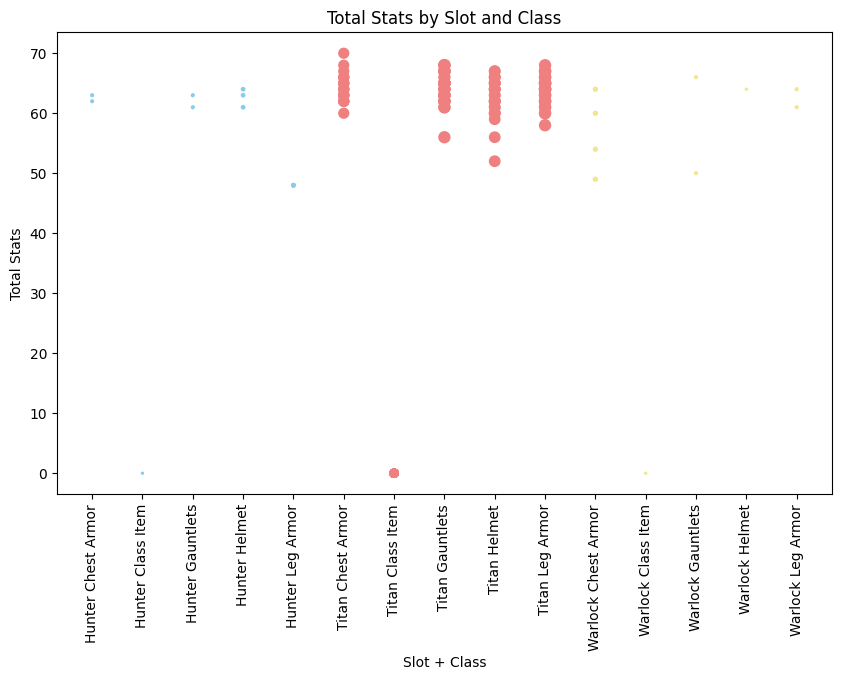

In [26]:
# create a graph that shows total stats by class and slot for all armor in the vault.  The larger the circle, the more we have with that stat total
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sort by class slot:
armor_df.sort_values('class_slot', ascending=True, inplace=True)

# Create a color map for the classes
color_map = {'Hunter': mcolors.CSS4_COLORS['skyblue'], 
             'Titan': mcolors.CSS4_COLORS['lightcoral'], 
             'Warlock': mcolors.CSS4_COLORS['khaki']}
armor_df['color'] = armor_df['d2_class'].map(color_map)

# Calculate the counts for each 'class_slot' value
counts = armor_df['class_slot'].value_counts()

plt.figure(figsize=(10,6))
# Pass the counts as the 's' argument to plt.scatter()
plt.scatter(armor_df['class_slot'], armor_df['total_stats'], s=counts[armor_df['class_slot']] * 2, color=armor_df['color'])
plt.xlabel('Slot + Class')
plt.ylabel('Total Stats')
plt.title('Total Stats by Slot and Class')
plt.xticks(rotation=90)
plt.show()

### Create ProfileOutfits which will let us calcuate permutations of all outfits in our vault

In [28]:
from src.armor import ProfileOutfits

# uncomment if we want to see only armor that isn't exotic
# non_exotic_armor_dict = {k: v for k, v in armor_dict.items() if not v.is_exotic}
# profile_outfits = ProfileOutfits(non_exotic_armor_dict)

# or uncomment this to use all armor in the vault
profile_outfits = ProfileOutfits(armor_dict)

### Identify all armor that is eclipsed by another piece of armor and can be safely deleted

In [29]:
# print out all armor that has the same or worse stats than another piece of armor of the same rarity and type
for lesser_armor, greater_armor in profile_outfits.find_eclipsed_armor():
    print(f"id:{lesser_armor.instance_id} OR id:{greater_armor.instance_id}")
    print(f"mob {lesser_armor.mobility}\tres {lesser_armor.resilience}\trec {lesser_armor.recovery}\tdis {lesser_armor.discipline}\tint {lesser_armor.intellect}\tstr {lesser_armor.strength}\t name {lesser_armor.item_name} <-- can be deleted")
    print(f"mob {greater_armor.mobility}\tres {greater_armor.resilience}\trec {greater_armor.recovery}\tdis {greater_armor.discipline}\tint {greater_armor.intellect}\tstr {greater_armor.strength}\t name {greater_armor.item_name} <-- is equal or better")

### Generate all possible outfits for each class type

In [30]:
# generate outfit permutations for each class
d2_class = "Hunter"
hunter_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(hunter_outfits)} outfit permutations for {d2_class}")

d2_class = "Titan"
titan_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(titan_outfits)} outfit permutations for {d2_class}")

d2_class = "Warlock"
warlock_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(warlock_outfits)} outfit permutations for {d2_class}")

Generated 3 outfit permutations for Hunter
Generated 1029340 outfit permutations for Titan
Generated 12 outfit permutations for Warlock


## Pick a class to work with for the rest of the notebook

In [31]:
# modify to the class you want to work with below
# d2_class, outfits = ("Hunter", hunter_outfits)
d2_class, outfits = ("Titan", titan_outfits)
# d2_class, outfits = ("Warlock", warlock_outfits)

In [32]:
# given the outfit permutations above PinnacleOutfits will generate a dataframe with weighted stats for each outfit
# this lets us see which armor pieces are in outfits that are "pinnacle" (have the highest total stats for a given stat combination)
from src.armor import PinnacleOutfits

pinnacle_outfits = PinnacleOutfits(outfits)
weighted_outfits_df = pinnacle_outfits.weighted_outfits_df
weighted_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
50,40,50,50,50,40,6917529648525374397,6917529880063573134,6917529184849965101,6917529961280235322,6917529837794630631,-1,1,330,320,330,330,330,320,370,380,380,380,370,370,370,370,360,380,380,370,380,370,370,420,420,420,…,410,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500
50,40,50,40,60,40,6917529648525374397,6917529880063573134,6917529184849965101,6917529961280235322,6917529837794630631,-1,1,330,320,330,320,340,320,370,380,370,390,370,370,360,380,360,370,390,370,380,360,380,420,410,430,…,410,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500
50,40,50,40,50,40,6917529648525374397,6917529880063573134,6917529184849965101,6917529961280235322,6917529837794630631,-1,1,320,310,320,310,320,310,360,370,360,370,360,360,350,360,350,360,370,360,360,350,360,410,400,410,…,410,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500
50,50,40,40,50,50,6917529648525374397,6917529880063573134,6917529184849965101,6917529838020129700,6917529837794630631,-1,1,330,330,320,320,330,330,380,370,370,380,380,370,370,380,380,360,370,370,370,370,380,420,420,430,…,410,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500
50,50,40,40,50,40,6917529648525374397,6917529

In [33]:
# finds the max value in each of the "weighted" columns grouped by num_artifice, then filter to those rows
weighted_outfits_max_df = pinnacle_outfits.weighted_outfits_max_df
weighted_outfits_max_df

exotic_hash,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1190497097,80,100,80,90,100,70,6917529985004289379,6917529811703155698,6917530014027943188,6917530014031375339,6917529837794630631,4,380,420,380,400,390,380,460,430,450,460,430,460,490,480,480,450,450,430,450,430,440,490,520,530,520,490,490,470,500,480,480,530,520,510,540,530,530,500,490,490,480
136355432,80,100,90,100,90,70,6917529985004289379,6917529969805602378,6917530014027943188,6917529810063031643,6917529837794630631,4,380,420,390,410,400,380,460,430,460,440,420,460,500,480,480,460,450,420,450,440,430,490,540,520,510,510,500,460,510,490,470,540,520,510,540,540,530,520,500,480,480
1453120846,70,100,100,90,90,70,6917529985004289379,6917529969805602378,6917530014027943188,6917529920989202724,6917529837794630631,4,380,420,410,400,410,390,440,450,450,440,430,480,470,470,480,470,490,460,450,450,450,500,500,510,500,520,520,500,490,490,480,530,540,540,520,540,530,530,520,520,500
2066430310,90,100,90,90,100,70,6917529985004289379,6917529931692510883,6917530014027943188,6917530014031375339,6917529837794630631,4,390,420,400,400,400,380,460,460,470,460,440,460,490,470,470,470,470,440,450,440,430,490,520,520,520,530,520,500,520,500,490,530,520,510,540,530,520,520,510,510,480
1734844651,90,100,90,100,100,70,6917529985004289379,6917529954460159304,6917530014027943188,6917530014031375339,6917529837794630631,4,390,420,400,410,410,380,470,450,480,460,440,460,510,490,480,470,470,430,460,450,430,500,540,530,530,520,510,490,520,510,490,540,520,510,550,550,530,520,510,500,490
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1160559849,80,100,90,90,100,80,6917529985004289379,6917529969805602378,6917530014027943188,6917530014537554114,6917529837794630631,4,380,420,400,390,410,390,460,440,450,450,430,460,490,490,490,450,480,440,450,440,440,490,520,530,520,500,510,480,500,490,490,530,540,520,540,540,540,530,490,510,480
3574051505,70,100,100,90,90,90,6917529873730892465,6917529969805602378,6917530014027943188,6917530014031375339,6917529837794630631,4,370,420,420,400,390,400,450,450,440,440,440,470,490,460,490,470,480,470,440,450,440,490,510,500,520,500,510,500,480,480,480,530,520,540,520,550,530,530,520,530,480
3539357318,80,100,100,80,100,80,6917529985004289379,6917529969805602378,6917530014027943188,6917529838206121233,6917529837794630631,4,390,430,410,390,

In [34]:
# filters the weighted outfits to only those outfits that have a weighted stat total equal to the maximum stat value for that exotic_hash
# this tells us which outfits hit that peak stat value so we can tell what armor pieces contribute
pinnacle_outfits_df = pinnacle_outfits.pinnacle_outfits_df
pinnacle_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
50,40,70,50,40,60,6917529648525374397,6917529969805602378,6917529966087741808,6917529961280235322,6917529837794630631,-1,2,360,350,380,360,350,370,400,430,410,400,420,420,400,390,410,430,420,440,400,420,410,470,450,440,…,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500,310
60,40,60,60,50,50,6917529967263531935,6917529843719879069,6917529966087741808,6917529838020129700,6917529837794630631,-1,2,380,360,380,380,370,370,420,440,440,430,430,420,420,410,410,440,430,430,430,430,420,480,480,470,…,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500,320
70,30,60,50,50,50,6917529967263531935,6917529843719879069,6917529966087741808,6917529985017336554,6917529837794630631,-1,2,380,340,370,360,360,360,410,440,430,430,430,400,390,390,390,420,420,420,410,410,410,470,460,460,…,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500,310
70,50,30,40,70,50,6917529967263531935,6917529843719879069,6917529780844212811,6917529844856375205,6917529837794630631,-1,1,380,360,340,350,380,360,430,410,420,450,430,390,400,430,410,380,410,390,420,400,430,460,470,500,…,400,460,460,480,470,450,480,520,480,500,480,490,460,460,470,440,500,550,530,540,530,530,490,520,510,500,560,530,550,550,570,540,540,530,520,500,310
50,40,70,70,40,50,6917529967263531935,691752937010522279

In [35]:
# iterate over the outfits in pinnacle_outfits_df and create a set of armor pieces that are in the outfits
pinnacle_armor = set()
for outfit in pinnacle_outfits_df.iter_rows():
    for i in range(6, 11):
        pinnacle_armor.add(outfit[i])

# emit the values in pinnacle_armor with `id:` in front of them so they can be used in the DIM search bar and joined together with an `OR`
dim_query = ' OR '.join([f'id:{item}' for item in pinnacle_armor])

print(f'is:{d2_class} is:armor NOT ({dim_query})')

is:Titan is:armor NOT (id:6917529813196847622 OR id:6917529587485261323 OR id:6917529764744340492 OR id:6917529393560700444 OR id:6917529770431531548 OR id:6917529193778442273 OR id:6917529324464114722 OR id:6917529840032441379 OR id:6917529598360325155 OR id:6917529707025879083 OR id:6917529184849965101 OR id:6917529856580311088 OR id:6917529961274086964 OR id:6917529969805602378 OR id:6917529780844212811 OR id:6917529974604403276 OR id:6917529972270824539 OR id:6917529202548086882 OR id:6917529386068196966 OR id:6917529173484692073 OR id:6917529188877930093 OR id:6917529316835581041 OR id:6917529531403186291 OR id:6917529360952144505 OR id:6917529960695484031 OR id:6917529370149952128 OR id:6917529370252605057 OR id:6917529770863262336 OR id:6917529967273842303 OR id:6917529837790557830 OR id:6917529370105222793 OR id:6917529880063573134 OR id:6917529811703158930 OR id:6917529127941739667 OR id:6917529931692510883 OR id:6917529880085896873 OR id:6917529869411041449 OR id:691752994337

### Print out the exotic pieces that we can reach triple 100s with

it will emit the combinations of stats that we can reach triple 100s with for each piece of exotic armor

It is actually looking for 3 stats that together are 250 points in total.  This would allow the use of five 10-point armor mods to hit triple 100

There is no consideration for stat modifications that class fragments bring into the mix.  It assumes neutral stat modifications outside of armor.

In [36]:
import itertools
from collections import defaultdict

# Initialize an empty dictionary
exotic_combinations = defaultdict(set)

# Define the attributes
attributes = ['mob', 'res', 'rec', 'dis', 'int', 'str']

stat_column_combinations = list(itertools.combinations(range(6), 3))

for outfit in pinnacle_outfits_df.iter_rows():
    exotic_hash = outfit[11] # Get the exotic_hash for the outfit
    
    for perm in stat_column_combinations:
        # Calculate the sum of the attributes
        attr_sum = sum(outfit[attr] for attr in perm)
        
        # If the sum is >= 250, add the permutation to the set
        if attr_sum >= 250:
            exotic_combinations[exotic_hash].add(perm)

# create a dict of the armor_hash to the name of the armor piece
armor_hash_to_name = {armor.item_hash: armor.item_name for armor in armor_dict.values()}

# Print the exotic_combinations dictionary
if len(exotic_combinations.items()) == 0:
    print("Sorry, no triple-100s found, guess you'll have to play more")
else:
    for exotic_hash, combinations in exotic_combinations.items():
        if exotic_hash == ProfileOutfits.NO_EXOTIC_HASH:
            print(f"No Exotic")
        else: 
            # iterate over the values in armor_dict to find the name of the exotic armor piece
            print(f"Exotic: {armor_hash_to_name[exotic_hash]} -- {exotic_hash}")

        # Sort the combinations alphabetically before printing
        for combination in sorted(combinations, key=lambda x: [attributes[i] for i in x]):
            print([attributes[i] for i in combination])

Exotic: One-Eyed Mask -- 2578771006
['res', 'dis', 'str']


### Print out all Legendary Armor Pieces and the exotic stat combinations where this armor piece was in a pinnacle outfit

It is sorted by the number of pinnacle outfits the armor piece was in, look at the bottom of the list for armor pieces that are only in pinnacle outfits that you don't care about

If this armor piece isn't the only one that can make this stat combo, it will print the stat combination out between `~` characters

If all stat combos are marked like `~res/dis/str~` that means that piece of armor can be safely replaces with another piece of armor and has no unique combinations.

```
Tusked Allegiance Hood -- Helmet -- id:6917529855693975489 -- m:2 r:20 r:10 d:23 i:2 s:8 -- total pinnacle outfits: 8 -- unique pinnacle outfits: 2
    No Exotic - 0 - ~res/dis/str~
    Briarbinds - 0 - ~res~
    Necrotic Grip - 0 - ~dis/str~
    Karnstein Armlets - 1 - res/dis
    Aeon Soul - 0 - ~dis/str~
    Phoenix Protocol - 1 - res/dis/str
    Wings of Sacred Dawn - 0 - ~dis/str~
    Rain of Fire - 0 - ~res/dis/str~
```
 
The Tusked Allegiance Hood was in 8 pinnacle outfits, but only 2 of them were unique to this armor piece
- `res/dis` on Karnstein Armlets
- `res/dis/str` on Phoenix Protocol

The other stat combinations were in other armor pieces, so they are marked as not unique


The output is in descending order, so the least valuable armor pieces are at the bottom

In [40]:
from src import report
import importlib
importlib.reload(report)
report.legendary_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df)

id:6917529837794630631 -- Deep Explorer Mark -- Class Item -- m:0 r:0 r:0 d:0 i:0 s:0 Σ:0 α:T-- total pinnacle outfits: 1722 -- unique pinnacle outfits: 1722
	 No Exotic - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec/dis  res/rec/int  res/rec/str  res/str  str
	 One-Eyed Mask - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/

In [42]:
# prints out exotic armor pieces and the stat combinations where this armor piece was in a pinnacle outfit
# sorts by exotic name so you can compare the stat combinations for each exotic
importlib.reload(report)
report.exotic_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df)

id:6917529208905661906 -- ACD/0 Feedback Fence -- Gauntlets -- m:10 r:12 r:10 d:8 i:13 s:10 Σ:63 α:F-- total pinnacle outfits: 41 -- unique pinnacle outfits: 41
	 ACD/0 Feedback Fence - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec/dis  res/rec/int  res/rec/str  res/str  str
id:6917529869411041449 -- Abeyant Leap -- Leg Armor -- m:6 r:16 r:12 d:11 i:10 s:12 Σ:67 α:F-- total pinnacle outfits: 41 -- unique pinnacle outfits: 41
	 Abeyant Leap - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mo

In [44]:
import polars as pl
from polars import col

# if you want to find all the outfits for a specific armor piece
def find_exotic_outfits_df(exotic_name, armor_dict, outfits_df):
    exotic_hash = ProfileOutfits.NO_EXOTIC_HASH
    for armor in armor_dict.values():
        if armor.item_name == exotic_name:
            exotic_hash = armor.item_hash
            break

    return outfits_df.filter(col('exotic_hash') == exotic_hash)

exotic_outfits_df = find_exotic_outfits_df("Lion Rampant", armor_dict, pinnacle_outfits_df)

exotic_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
30,60,70,30,50,70,6917529648525374397,6917529837790555450,6917529966087741808,6917529594085571504,6917529837794630631,3539357318,3,340,370,380,340,360,380,400,410,370,390,410,440,400,420,440,410,430,450,390,410,430,470,430,450,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,310
30,90,40,40,50,70,6917529648525374397,6917529837790555450,6917529837790557830,6917529838206121233,6917529837794630631,3539357318,3,350,410,360,360,370,390,440,390,390,400,420,450,450,460,480,400,410,430,410,430,440,480,480,490,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,320
80,40,40,50,70,30,6917529967263531935,6917529880063573134,6917529952312689132,6917529838206121233,6917529837794630631,3539357318,1,390,350,350,360,380,340,430,430,440,460,420,390,400,420,380,400,420,380,430,390,410,470,480,500,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,310
70,50,40,40,90,20,6917529967263531935,6917529880063573134,6917529198787755274,6917529838206121233,6917529837794630631,3539357318,1,380,360,350,350,400,330,430,420,420,470,400,400,400,450,380,390,440,370,440,370,420,470,470,520,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,310
70,50,40,50,60,50,691752

In [47]:
# find a particular exotic armor piece and stat combo you're interested in
stats = ['resilience', 'discipline', 'strength']
weighted_column_name = 'weighted_' + '_'.join(stats)
weighted_max_column_name = weighted_column_name + '_max'
filtered_exotic_outfits_df = exotic_outfits_df.filter(col(weighted_column_name) == col(weighted_max_column_name))
filtered_exotic_outfits_df


mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
20,100,40,50,40,70,6917529780942050118,6917529837790555450,6917529837790557830,6917529594085571504,6917529837794630631,3539357318,3,340,420,360,370,360,390,440,380,390,380,410,460,470,460,490,410,400,430,410,440,430,480,490,480,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,320
20,100,50,50,50,60,6917529838054459293,6917529801674590626,6917529837790557830,6917529594085571504,6917529837794630631,3539357318,3,350,430,380,380,380,390,450,400,400,400,410,480,480,480,490,430,430,440,430,440,440,500,500,500,…,390,460,440,450,470,440,480,480,490,490,460,490,450,450,440,450,500,520,530,520,500,520,490,510,490,500,530,550,540,530,540,550,530,500,520,490,330


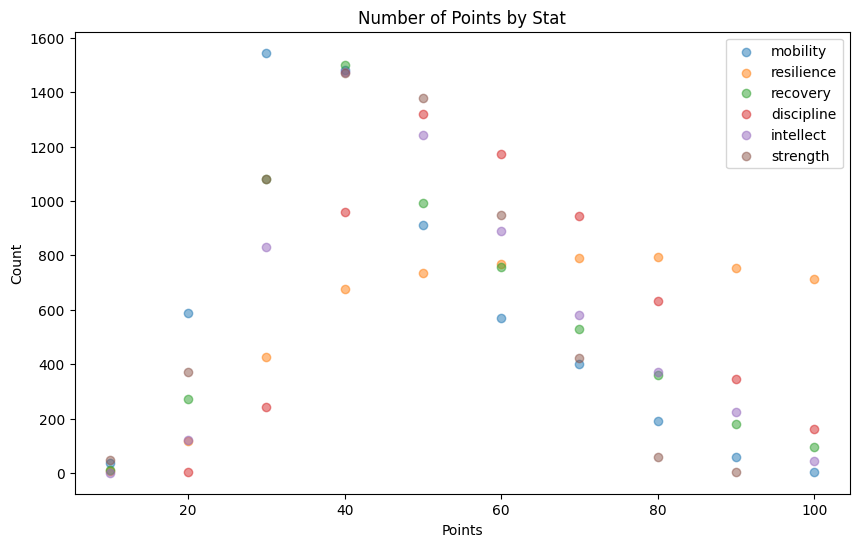

In [48]:
import polars as pl
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format
long_df = pinnacle_outfits_df.melt(
    value_vars=["mobility", "resilience", "recovery", "discipline", "intellect", "strength"],
)

# Rename the columns to 'stat' and 'points'
long_df = long_df.with_columns(
    long_df["variable"].alias("stat"),
    long_df["value"].alias("points"),
)

# Count the number of outfits for each point total for each stat
counts_df = long_df.group_by(["stat", "points"]).agg(pl.count("stat").alias("count"))

# Convert to pandas for easier plotting
counts_df = counts_df.to_pandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
for stat in ["mobility", "resilience", "recovery", "discipline", "intellect", "strength"]:
    stat_df = counts_df[counts_df["stat"] == stat]
    plt.scatter(
        stat_df["points"],
        stat_df["count"],  # Y-axis
        alpha=0.5,
        label=stat,
    )
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Number of Points by Stat")
plt.legend()
plt.show()

### Scratch for testing specific outfits and comparing against DIM

In [49]:
def print_row_weighted_vs_max(row):
    # print the row so that we show the weighted value compared to the weighted max value
    row = row.to_dict()
    for key, value in row.items():
        if not (key.startswith('weighted_') or key.endswith('_max')):
            print(f"{key}: {value[0]}")
        if key.startswith('weighted_') and not key.endswith('_max'):
            max_key = key + '_max'
            real_value = value[0]
            max_value = row[max_key][0]
            if real_value == max_value:
                print(f"{key}: {value[0]} == {row[max_key][0]} ************************************")
            else:
                print(f"{key}: {value[0]} < {row[max_key][0]}")

def print_outfit_stats(row):
    helmet_id = row['helmet'][0]
    gauntlets_id = row['gauntlets'][0]
    chest_id = row['chest_armor'][0]
    leg_id = row['leg_armor'][0]
    class_item_id = row['class_item'][0]

    mobility = 0
    resilience = 0
    recovery = 0
    discipline = 0
    intellect = 0
    strength = 0
    
    for id in [helmet_id, gauntlets_id, chest_id, leg_id, class_item_id]:
        armor = armor_dict[id]
        mobility += armor.mobility
        resilience += armor.resilience
        recovery += armor.recovery
        discipline += armor.discipline
        intellect += armor.intellect
        strength += armor.strength
        print(f"{armor.mobility}\t{armor.resilience}\t{armor.recovery}\t{armor.discipline}\t{armor.intellect}\t{armor.strength}\t{armor.total_stats}\t{armor.is_artifice}\t{armor.item_name}\t{armor.instance_id}")

    print(f"{mobility}\t{resilience}\t{recovery}\t{discipline}\t{intellect}\t{strength}\t<-- base outfit stats")
    print(f"{row['mobility'][0]}\t{row['resilience'][0]}\t{row['recovery'][0]}\t{row['discipline'][0]}\t{row['intellect'][0]}\t{row['strength'][0]}\t<-- outfit with applied artifice + masterwork & rounded to useful tiers")


In [50]:
# find rows in ploutfits_df that are duplicate rows for all fields - should not happen
pinnacle_outfits_df.filter(pinnacle_outfits_df.is_duplicated())

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [31]:
# one of my specific outfits I can see in DIM - shows all permutations of this outfit that have unique stat totals
helmet_id = 6917529862437575151
gauntlets_id = 6917529838031225999
chest_id = 6917529838898582109
leg_id = 6917530017559101392
class_item_id=6917529583788947730

outfit = weighted_outfits_df.filter(
    (weighted_outfits_df['helmet'] == helmet_id) & 
    (weighted_outfits_df['gauntlets'] == gauntlets_id) & 
    (weighted_outfits_df['chest_armor'] == chest_id) &
    (weighted_outfits_df['leg_armor'] == leg_id) &
    (weighted_outfits_df['class_item'] == class_item_id))

for i in range(outfit.height):
    row = outfit[i]
    print_outfit_stats(row)
    print_row_weighted_vs_max(row)
# outfit

21	9	2	28	2	2	64	True	Deep Explorer Hood	6917529862437575151
6	26	2	23	2	6	65	True	Deep Explorer Gloves	6917529838031225999
6	26	4	13	8	10	67	False	Starfire Protocol	6917529838898582109
2	29	2	8	2	23	66	False	Veiled Tithes Boots	6917530017559101392
0	0	0	0	0	0	0	True	Corrupting Echo Bond	6917529583788947730
35	90	10	72	14	41	<-- base outfit stats
50	100	20	80	20	50	<-- outfit with applied artifice + masterwork & rounded to useful tiers
mobility: 50
resilience: 100
recovery: 20
discipline: 80
intellect: 20
strength: 50
helmet: 6917529862437575151
gauntlets: 6917529838031225999
chest_armor: 6917529838898582109
leg_armor: 6917530017559101392
class_item: 6917529583788947730
exotic_hash: 2082483156
num_artifice: 3
weighted_mobility: 370 < 420
weighted_resilience: 420 < 430
weighted_recovery: 340 < 420
weighted_discipline: 400 < 430
weighted_intellect: 340 < 420
weighted_strength: 370 < 420
weighted_mobility_resilience: 470 < 480
weighted_mobility_recovery: 390 < 460
weighted_mobility_discip

# Tests

In [51]:
import unittest
import random
from src.armor import Armor, ProfileArmor, random_64_int
import json

random.seed(42)

class TestOutfits(unittest.TestCase):
    def armor_list_to_dict(self, armor_list):
        return {armor.instance_id: armor for armor in armor_list}

    def random_stat(self):
        return random.randint(1,42)
    
    def random_armor(self, slot, rarity="Legendary", item_hash=None):
        if item_hash is None:
            item_hash = random_64_int()
        return Armor(slot=slot, rarity=rarity, item_hash=item_hash, mobility=self.random_stat(), resilience=self.random_stat(), recovery=self.random_stat(), discipline=self.random_stat(), intellect=self.random_stat(), strength=self.random_stat())
    
    def setUp(self):
        self.titan_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, d2_class="Titan")
        self.helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6)
        self.artifice_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, is_artifice=True)
        self.gauntlets = Armor(slot="Gauntlets", mobility=7, resilience=7, recovery=7, discipline=7, intellect=7, strength=7)
        self.chest_armor = Armor(slot="Chest Armor", mobility=8, resilience=8, recovery=8, discipline=8, intellect=8, strength=8)
        self.leg_armor = Armor(slot="Leg Armor", mobility=9, resilience=9, recovery=9, discipline=9, intellect=9, strength=9)
        self.artifice_leg_armor = Armor(slot="Leg Armor", mobility=11, resilience=11, recovery=11, discipline=5, intellect=5, strength=20, is_artifice=True)
        self.class_item = Armor(slot="Class Item", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0)
        self.exotic_helmet = Armor(slot="Helmet", item_hash=200, rarity="Exotic", mobility=2, resilience=20, recovery=10, discipline=30, intellect=2, strength=2)
        self.exotic_helmet2 = Armor(slot="Helmet", item_hash=300, rarity="Exotic", mobility=11, resilience=11, recovery=11, discipline=11, intellect=11, strength=11)
        self.exotic_gauntlets = Armor(slot="Gauntlets", item_hash=400, rarity="Exotic", mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10)

        # all armor pieces in a dictionary keyed by instance_id
        self.armor_dict = self.armor_list_to_dict([
            self.titan_helmet,
            self.helmet,
            self.artifice_helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.artifice_leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])

        # all unspecified stats are zero
        self.helmet_0 = Armor(slot="Helmet")
        self.gauntlets_0 = Armor(slot="Gauntlets")
        self.chest_armor_0 = Armor(slot="Chest Armor")
        self.leg_armor_0 = Armor(slot="Leg Armor")
        self.class_item_0 = Armor(slot="Class Item")

    def test_armor(self):
        armor = self.helmet
        self.assertEqual(armor.total_stats, 36)
        self.assertEqual(armor.class_slot, "Warlock Helmet")
        self.assertFalse(armor.is_exotic)

        exotic_armor = self.exotic_helmet
        self.assertTrue(exotic_armor.is_exotic)

    def test_filter_and_group_armor(self):
        profile_outfits = ProfileOutfits(self.armor_dict)
        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Warlock")

        self.assertIsNotNone(exotic_armor)
        self.assertEqual(len(exotic_armor), 2)
        self.assertEqual(exotic_armor["Helmet"], [self.exotic_helmet, self.exotic_helmet2])
        self.assertEqual(exotic_armor["Gauntlets"], [self.exotic_gauntlets])
        self.assertIsNotNone(non_exotic_armor)
        self.assertEqual(len(non_exotic_armor), 5)
        self.assertEqual(non_exotic_armor["Helmet"], [self.helmet, self.artifice_helmet])
        self.assertEqual(non_exotic_armor["Gauntlets"], [self.gauntlets])
        self.assertEqual(non_exotic_armor["Chest Armor"], [self.chest_armor])
        self.assertEqual(non_exotic_armor["Leg Armor"], [self.leg_armor, self.artifice_leg_armor])
        self.assertEqual(non_exotic_armor["Class Item"], [self.class_item])

        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Titan")
        self.assertEqual(len(exotic_armor), 0)
        self.assertEqual(len(non_exotic_armor), 1)
        self.assertEqual(non_exotic_armor["Helmet"], [self.titan_helmet])

    def test_generate_class_outfits(self):
        armor_dict = self.armor_list_to_dict([
            self.helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 4)

        # point totals would be 44 for each stat, but we round down to the nearest 5 for the tier
        self.assertEqual(outfits[0], (40, 40, 40, 40, 40, 40, self.helmet.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, -1, 0))
        self.assertEqual(outfits[1], (35, 50, 40, 60, 35, 35, self.exotic_helmet.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, self.exotic_helmet.item_hash, 0))
        self.assertEqual(outfits[2], (45, 45, 45, 45, 45, 45, self.exotic_helmet2.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, self.exotic_helmet2.item_hash, 0))
        self.assertEqual(outfits[3], (40, 40, 40, 40, 40, 40, self.helmet.instance_id, self.exotic_gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, 400, 0))

    def test_generate_many_class_outfits(self):
        armor_list=[]
        for i in range(10):
            armor_list.append(self.random_armor("Helmet"))
            armor_list.append(self.random_armor("Gauntlets"))
            armor_list.append(self.random_armor("Chest Armor"))
            armor_list.append(self.random_armor("Leg Armor"))
            armor_list.append(self.random_armor("Class Item"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # 4 slots with 20 pieces per slot, 10^4 = 10,000
        self.assertEqual(len(outfits), 10**4)

        for i in range(2):
            armor_list.append(self.random_armor("Helmet", "Exotic"))
            armor_list.append(self.random_armor("Gauntlets", "Exotic"))
            armor_list.append(self.random_armor("Leg Armor", "Exotic"))
            armor_list.append(self.random_armor("Chest Armor", "Exotic"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # same 4 slots with 10 legendary pieces per slot, but now 2 exotic pieces per slot that each need to be combined with 3 slots of 10 legendary pieces 
        self.assertEqual(len(outfits), 10**4 + 8 * 10**3)

    def test_outfit_permutations_zero_artifice(self):
        no_artifice_armor_dict = self.armor_list_to_dict([self.helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(no_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        # stats in outfit are 10 as we're assuming all armor pieces are masterworked, even though they have all stats at zero
        self.assertEqual(outfits[0], (10, 10, 10, 10, 10, 10, self.helmet_0.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 0))

    def test_outfit_permutations_one_artifice_stats_zero(self):
        # if we have one piece of artifice armor, but the 3 points it gives doesn't increase a tier, we'll still only have 1 outfit
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        self.assertEqual(outfits[0], (10, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1))

    def test_outfit_permutations_one_artifice_stats_two(self):
        # if we have one piece of artifice armor, but the 2 base points it has are enough to get it close enough to the next tier, we'll have 6 outfits, one for each stat bumped up
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 6)
        self.assertIn((15, 10, 10, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 15, 10, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 15, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 15, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 10, 15, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 10, 10, 15, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)

    def test_outfit_permutations_two_artifice_stats_zero(self):
        # if we have two pieces of artifice armor, but we're starting with all stats ending in 0, we'll get 6 outfits as we can add 6 to each stat
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        artifice_gauntlets_0 = Armor(slot="Gauntlets", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 7)
        self.assertIn((10, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 15, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 15, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 10, 15, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

    def test_outfit_permutations_two_artifice_stats_two(self):
        # # if we have two pieces of artifice armor, and we start with base stats of 4 in each stat, we'll get permutations we can add either 6 to every stat or 3 to 2 stats
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_gauntlets_2 = Armor(slot="Gauntlets", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_2, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 21)

        self.assertIn((20, 10, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 20, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 20, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 20, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 20, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 10, 20, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((15, 15, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 15, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 15, 15, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 15, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 10, 15, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 15, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 10, 10, 15, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

    def test_outfit_permutations_five_artifice_stats(self):
        # if we have five pieces of artifice armor, and we start with base stats of 0 in each stat
        # we'll get permutations we can add:
        # - 15 to one stat - 6 ways 
        # - 12 to one stat and 3 to one stat - 30 ways
        # - 9 to one stat and 6 to one stat - 30 ways
        # - 9 to one stat and 3 to two stats - 60 ways
        # - 6 to two stats and 3 to one stat - 60 ways
        # - 6 to one stat and 3 to three stats - 60 ways
        # - 3 to five stats - 6 ways
        # but! some of those ways don't give us new stat combos because we only care about increments of 5 on a stat
        # if all stats end in 0, adding +3 ~ +0 and +9 ~ +6 - redundant combos can be removed
        # if all stats end in 1, adding +3 ~ +0 and +9 ~ +12
        # if all stats end in 2, adding +6 ~ +3 and +9 ~ +12
        # if all stats end in 3, adding +6 ~ +3 and +12 ~ +15
        # if all stats end in 4, adding +9 ~ +6 and +12 ~ +15
        # stats of 5 loop back to the same as 0

        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True)
        artifice_helmet_1 = Armor(slot="Helmet", mobility=1, resilience=1, recovery=1, discipline=1, intellect=1, strength=1, is_artifice=True)
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_helmet_3 = Armor(slot="Helmet", mobility=3, resilience=3, recovery=3, discipline=3, intellect=3, strength=3, is_artifice=True)
        artifice_helmet_4 = Armor(slot="Helmet", mobility=4, resilience=4, recovery=4, discipline=4, intellect=4, strength=4, is_artifice=True)
        artifice_gauntlets_0 = Armor(slot="Gauntlets", is_artifice=True)
        artifice_chest_0 = Armor(slot="Chest Armor", is_artifice=True)
        artifice_legs_0 = Armor(slot="Leg Armor", is_artifice=True)
        artifice_class_0 = Armor(slot="Class Item", is_artifice=True)

        profile_outfits_0 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_0 = profile_outfits_0.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_0), 34)

        profile_outfits_1 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_1, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_1 = profile_outfits_1.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_1), 64)

        profile_outfits_2 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_2 = profile_outfits_2.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_2), 137)

        profile_outfits_3 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_3, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_3 = profile_outfits_3.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_3), 167)

        profile_outfits_4 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_4, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_4 = profile_outfits_4.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_4), 237)
        
        # print outfits_4 to a file in data as json
        with open("data/outfits_4.json", "w") as f:
            json.dump(outfits_4, f, indent=4)



unittest.main(argv=[''], verbosity=2, exit=False)

test_armor (__main__.TestOutfits.test_armor) ... ok
test_filter_and_group_armor (__main__.TestOutfits.test_filter_and_group_armor) ... ok
test_generate_class_outfits (__main__.TestOutfits.test_generate_class_outfits) ... FAIL
test_generate_many_class_outfits (__main__.TestOutfits.test_generate_many_class_outfits) ... ok
test_outfit_permutations_five_artifice_stats (__main__.TestOutfits.test_outfit_permutations_five_artifice_stats) ... FAIL
test_outfit_permutations_one_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_two) ... FAIL
test_outfit_permutations_one_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_zero) ... ok
test_outfit_permutations_two_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_two) ... FAIL
test_outfit_permutations_two_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_zero) ... FAIL
test_outfit_permutations_zero_artifice (__